# Unsupervised Domain Adaptation

[Ссылка на исходный блокнот](https://colab.research.google.com/drive/1mgggBqjsAxlr6Hkv2EJOpR6ml7Opo1g0?usp=sharing)

Реализуем подход из статьи **Unsupervised Domain Adaptation by Backpropagation**.

https://arxiv.org/abs/1409.7495

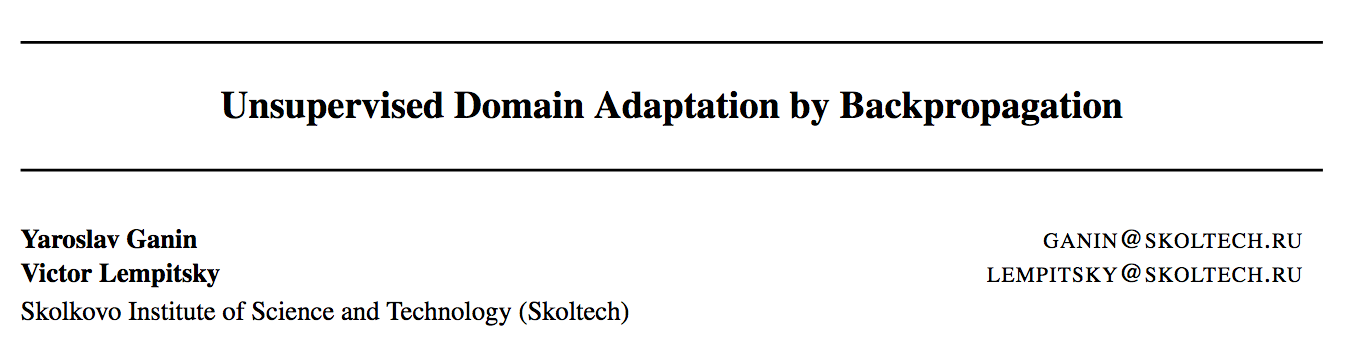

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pickle
import math

import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchvision
from PIL import Image
import matplotlib.pyplot as plt


Выполним **доменную адаптацию** **(domain adaptation)** от исходного набора данных (MNIST) к целевому набору данных (MNIST-M).

Сначала нам нужно создать целевой набор данных:

In [3]:
!gdown '17mbFFGl1JdhAd7KG6CGqpjqAPgjbnT_n'

Downloading...
From (original): https://drive.google.com/uc?id=17mbFFGl1JdhAd7KG6CGqpjqAPgjbnT_n
From (redirected): https://drive.google.com/uc?id=17mbFFGl1JdhAd7KG6CGqpjqAPgjbnT_n&confirm=t&uuid=7726601c-d160-43fc-a4d6-3522eb2f742e
To: /content/mnistm.py
100% 2.74k/2.74k [00:00<00:00, 10.7MB/s]


In [4]:
from mnistm import create_mnistm

create_mnistm()

Creating MNIST-M... That may takes a minute
Loading BSR training images


100%|██████████| 9.91M/9.91M [00:02<00:00, 4.16MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 130kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.26MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.13MB/s]


Building train set...
Processing example 0
Processing example 10000
Processing example 20000
Processing example 30000
Processing example 40000
Processing example 50000
Building test set...
Processing example 0
Done!


Затем загрузим набор данных MNIST и вычислим его среднее значение и стандартное отклонение (по обучающей выборке).

Мы будем использовать эти значения для **нормализации** как MNIST, так и MNIST-M.

In [5]:
mnist_pixels = torchvision.datasets.MNIST('.', train=True, download=True).data / 255
mean = mnist_pixels.mean().item()
std = mnist_pixels.std().item()

print(f"Mean {mean} and Std {std}")
mean = torch.tensor([mean, mean, mean])
std = torch.tensor([std, std, std])

Mean 0.13066047430038452 and Std 0.30810782313346863


Создим загрузчики (dataloaders) для MNIST

In [6]:
transform = transforms.Compose([
  transforms.ToTensor(),
  lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x,
  transforms.Normalize(mean, std)
])

mnist_train = torchvision.datasets.MNIST('.', train=True, transform=transform)
mnist_test = torchvision.datasets.MNIST('.', train=False, transform=transform)

source_train_loader = DataLoader(mnist_train, batch_size=128)
source_test_loader = DataLoader(mnist_test, batch_size=128)

Визуализируем примеры

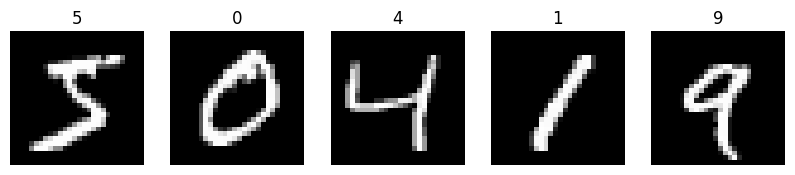

In [7]:
plt.figure(figsize=(10, 7))

for i in range(5):
  ax = plt.subplot(1, 5, i + 1)
  ax.axis('off')

  x, y = mnist_train[i]
  img = ((x * std[:, None, None] + mean[:, None, None]) * 255).permute(1, 2, 0)
  plt.imshow(img.numpy().astype(np.uint8), cmap='gray')
  plt.title(y)

Аналогично для MNIST-M. Создадим простой `Dataset` для загрузки набора данных, который был сериализован в формате pickle:

In [8]:
with open('mnistm_data.pkl', 'rb') as f:
  mnist_m = pickle.load(f)

class MNISTM(torch.utils.data.Dataset):
  def __init__(self, x, y, transform):
    self.x, self.y = x, y
    self.transform = transform

  def __len__(self):
    return len(self.x)

  def __getitem__(self, index):
    x, y = self.x[index], self.y[index]
    x = self.transform(x)

    return x, y

mnistm_train = MNISTM(mnist_m["x_train"], mnist_m["y_train"], transform)
mnistm_test = MNISTM(mnist_m["x_test"], mnist_m["y_test"], transform)

target_train_loader = DataLoader(mnistm_train, batch_size=128)
target_test_loader = DataLoader(mnistm_test, batch_size=128)

Визуализируем примеры из **MNIST-M**.

Обратим внимание, что **MNIST-M** сильно похож на MNIST. Единственное отличие заключается в том, что первый имеет цвета и текстуры, и, таким образом, является RGB изображением. Поскольку MNIST в оттенках серого, мы продублировали его каналы трижды.

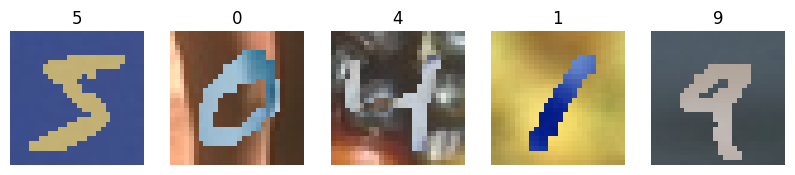

In [9]:
plt.figure(figsize=(10, 7))

for i in range(5):
  ax = plt.subplot(1, 5, i + 1)
  ax.axis('off')

  x, y = mnistm_train[i]
  img = ((x * std[:, None, None] + mean[:, None, None]) * 255).permute(1, 2, 0)
  plt.imshow(img.numpy().astype(np.uint8))
  plt.title(y)

Теперь давайте реализуем эту базовую сеть, рисунок которой взят из статьи. Спроектируем модель так, чтобы свертки не уменьшали пространственные размеры:

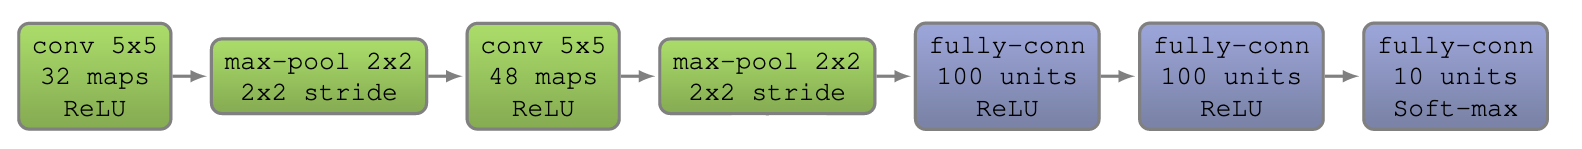

In [10]:
class NaiveNet(nn.Module):
  def __init__(self):
    super().__init__()

    self.cnn = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2),  # 32x28x28
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0),  # 32x14x14
        nn.Conv2d(32, 48, kernel_size=5, stride=1, padding=2),  # 48x14x14
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0),  # 48x7x7
    )

    self.classif = nn.Sequential(
        nn.Linear(7 * 7 * 48, 100),
        nn.ReLU(inplace=True),
        nn.Linear(100, 100),
        nn.ReLU(inplace=True),
        nn.Linear(100, 10)
    )

  def forward(self, x):
    batch_size = len(x)

    x = self.cnn(x)
    x = x.view(batch_size, -1)
    return self.classif(x)


NaiveNet()(torch.randn(2, 3, 28, 28)).shape

torch.Size([2, 10])

In [11]:
def eval_model(net, loader):
  net.eval()

  acc, loss = 0, 0.
  c = 0
  for x, y in loader:
    c += len(x)

    with torch.no_grad():
      logits = net(x.cuda()).cpu()

    loss += F.cross_entropy(logits, y).item()
    acc += (logits.argmax(dim=1) == y).sum().item()

  return round(100 * acc / c, 2), round(loss / len(loader), 5)

Давайте обучим нашу модель, но только на исходном наборе данных (MNIST). Затем мы оценим ее производительность на целевом наборе данных (MNIST-M).

Обратите внимание, что используется **планировщик скорости обучения** (**learning rate scheduler**). Мы обновляем скорость обучения после каждой эпохи в соответствии с функцией, определенной с помощью *lambda*, следуя спецификации статьи.

Устанавливаем начальную скорость обучения равной 1.0, потому что `LambdaLR` определяет *мультипликативный коэффициент* (*multiplicative factor*) базовой скорости обучения.

Часто полезно аналогичным образом уменьшать скорость обучения во время обучения, чтобы облегчить сходимость, как только модель нашла хороший локальный минимум.

In [12]:
epochs = 20

naive_net = NaiveNet().cuda()

optimizer = torch.optim.SGD(naive_net.parameters(), lr=1.0, momentum=0.9)

mu0, alpha, beta = 0.01, 10, 0.75
scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lambda e: 0.01 / (1 + alpha * e / epochs) ** beta
)

for epoch in range(epochs):
  train_loss = 0.

  for x, y in source_train_loader:
    x, y = x.cuda(), y.cuda()

    optimizer.zero_grad()
    logits = naive_net(x)
    loss = F.cross_entropy(logits, y)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
  print(f'Epoch {epoch}, train loss: {round(train_loss / len(source_train_loader), 5)}')
  scheduler.step()
  print(f"\tLearning rate = {optimizer.param_groups[0]['lr']}")

test_acc, test_loss = eval_model(naive_net, source_test_loader)
print(f"Test loss: {test_loss}, test acc: {test_acc}")

Epoch 0, train loss: 0.34662
	Learning rate = 0.007377879464668811
Epoch 1, train loss: 0.06161
	Learning rate = 0.005946035575013606
Epoch 2, train loss: 0.04104
	Learning rate = 0.005029733718731742
Epoch 3, train loss: 0.03166
	Learning rate = 0.004386913376508308
Epoch 4, train loss: 0.02593
	Learning rate = 0.003907949713906801
Epoch 5, train loss: 0.02193
	Learning rate = 0.0035355339059327372
Epoch 6, train loss: 0.01882
	Learning rate = 0.0032366118113821563
Epoch 7, train loss: 0.0165
	Learning rate = 0.002990697562442441
Epoch 8, train loss: 0.0145
	Learning rate = 0.00278437664873526
Epoch 9, train loss: 0.01281
	Learning rate = 0.0026084743001221454
Epoch 10, train loss: 0.01137
	Learning rate = 0.0024564898981344154
Epoch 11, train loss: 0.01018
	Learning rate = 0.002323680802425408
Epoch 12, train loss: 0.00916
	Learning rate = 0.0022065006130979154
Epoch 13, train loss: 0.0083
	Learning rate = 0.0021022410381342864
Epoch 14, train loss: 0.00757
	Learning rate = 0.0020087

Производительность менее чем за 10 эпох отличная на MNIST, более 99% точности. Но этот набор данных довольно простой.

Теперь вопрос: может ли наша модель обобщаться на слегка отличающийся домен MNIST-M?

In [13]:
test_acc, test_loss = eval_model(naive_net, target_test_loader)
print(f"Test loss: {test_loss}, test acc: {test_acc}")

Test loss: 1.67539, test acc: 54.41


Нет... У вас получится точность от 53 до 57%, что намного меньше, чем 99% на MNIST.

Мы собираемся реализовать **DANN**, **Domain Adversarial Neural Network** (Доменно-состязательную нейронную сеть). Ключевой частью этой сети является ветвь предсказания домена и **слой обращения градиента** (**gradient reversal layer** - **GRL**).

GRL будет обращать градиент между классификатором домена (розовым) и экстрактором признаков (зеленым).

Что это означает интуитивно? Градиент классификатора домена должен помогать лучше классифицировать домен. Поэтому, если мы обратим его перед концом экстрактора признаков, мы заставим эту CNN делать противоположное: делать признаки максимально агностичными к домену. Это означает, что признаки MNIST и MNIST-M будут похожими, и будет сохранена только информация о цифре.

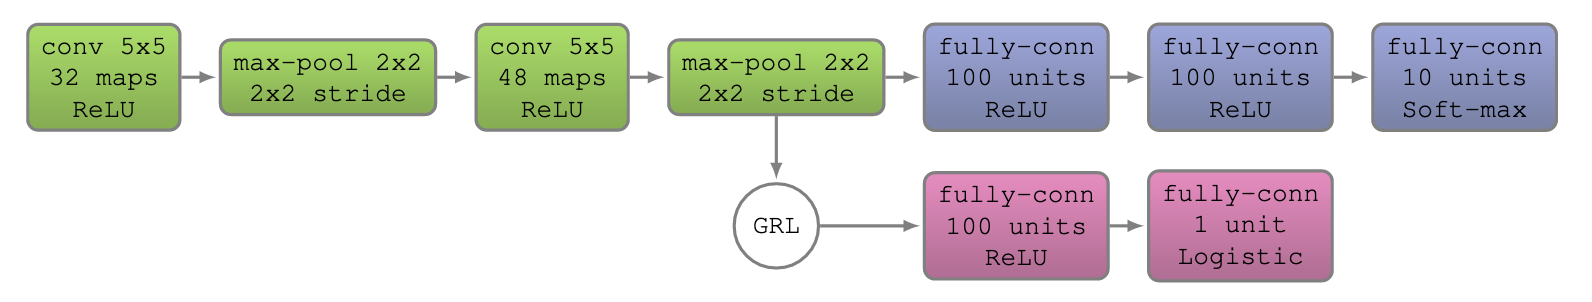

Чтобы применить пользовательский backward в PyTorch, вам нужно определить `torch.autograd.Function`.

Forward прост, мы ничего не делаем, кроме сохранения фактора, который нам понадобится в backward проходе.

В backward проходе нам нужно вернуть столько градиентов, сколько есть входов (здесь два). Поскольку фактор не является чем-то, что нужно оптимизировать, мы возвращаем `None`.

Теперь, учитывая фактор (который по умолчанию равен -1, т.е. "обратный"), определим модифицированный градиент:



In [14]:
class GradientReversal(torch.autograd.Function):
  @staticmethod
  def forward(ctx, x, factor=-1):
    ctx.save_for_backward(torch.tensor(factor))
    return x

  @staticmethod
  def backward(ctx, grad):
    factor, = ctx.saved_tensors

    return factor * grad, None

In [15]:
x = torch.tensor([42.], requires_grad=True)
y = torch.tensor([1337.], requires_grad=True)
o = x * y
o.backward()
print(x.grad.item())

x = torch.tensor([42.], requires_grad=True)
y = torch.tensor([1337.], requires_grad=True)
o = GradientReversal.apply(x * y, -1)
o.backward()
print(x.grad.item())

1337.0
-1337.0


Чтобы использовать `Function` PyTorch, вызовем ее метод apply.

Теперь реализуем DANN.

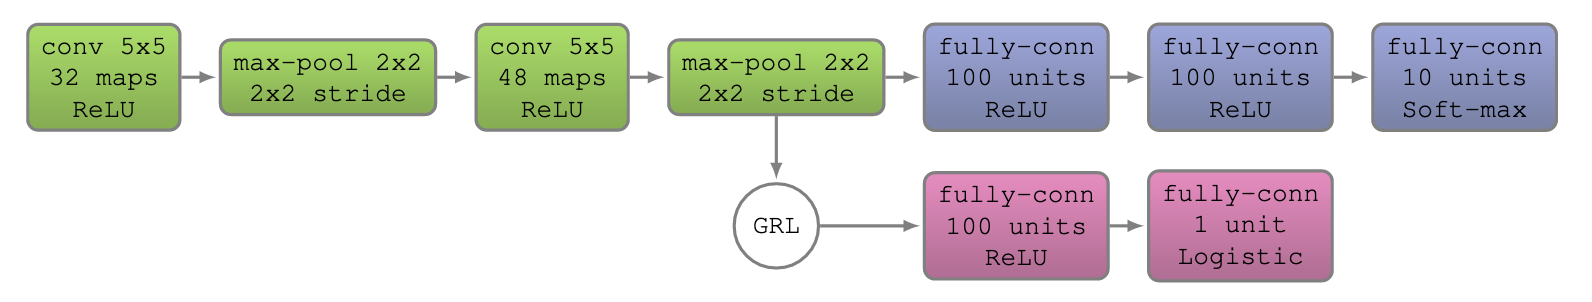

In [16]:
class DANN(nn.Module):
  def __init__(self):
    super().__init__()

    self.cnn = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2),  # 32x28x28
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0),  # 32x14x14
        nn.Conv2d(32, 48, kernel_size=5, stride=1, padding=2),  # 48x14x14
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0),  # 48x7x7
    )

    self.classif = nn.Sequential(
        nn.Linear(7 * 7 * 48, 100),
        nn.ReLU(inplace=True),
        nn.Linear(100, 100),
        nn.ReLU(inplace=True),
        nn.Linear(100, 10)
    )

    self.domain = nn.Sequential(
        nn.Linear(7 * 7 * 48, 100),
        nn.ReLU(inplace=True),
        nn.Linear(100, 1)
    )

    self.grl = GradientReversal.apply

  def forward(self, x, factor=1):
    batch_size = len(x)

    x = self.cnn(x)
    x = x.view(batch_size, -1)

    class_pred = self.classif(x)
    domain_pred = self.domain(self.grl(x, -1 * factor))

    return class_pred, domain_pred


In [17]:
def eval_dann(net, loader, source=True):
  net.eval()

  c_acc, d_acc, cls_loss, d_loss = 0, 0, 0., 0.
  c = 0
  for x, y in loader:
    x = x.cuda()
    if source:
      d = torch.ones(len(x))
    else:
      d = torch.zeros(len(x))

    c += len(x)

    with torch.no_grad():
      cls_logits, domain_logits = net(x.cuda())
      cls_logits, domain_logits = cls_logits.cpu(), domain_logits.cpu()

    cls_loss += F.cross_entropy(cls_logits, y).item()
    d_loss += F.binary_cross_entropy_with_logits(domain_logits[:, 0], d).item()

    c_acc += (cls_logits.argmax(dim=1) == y).sum().item()
    d_acc += ((torch.sigmoid(domain_logits[:, 0]) > 0.5).float() == d).sum().item()

  return round(100 * c_acc / c, 2), round(100 * d_acc / c, 2), round(cls_loss / len(loader), 5), round(d_loss / len(loader), 5)

In [18]:
source_train_loader = DataLoader(mnist_train, batch_size=64)
target_train_loader = DataLoader(mnistm_train, batch_size=64)

len(source_train_loader), len(target_train_loader)

(938, 938)

Для GRL использование фактора -1 напрямую приведет к очень плохой производительности. Поэтому мы будем постепенно увеличивать фактор во время обучения.

Ниже показан график функции, которую будем использовать (модифицированная версия из статьи):

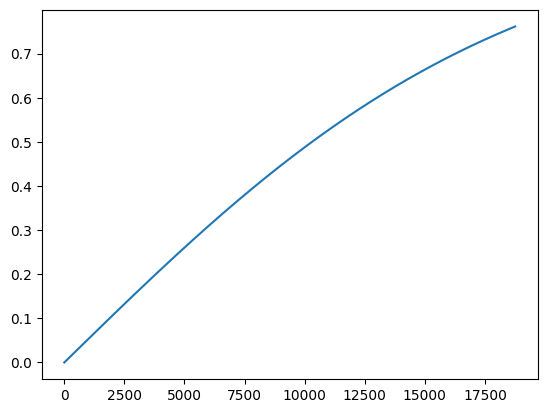

In [19]:
nb_iters = (len(source_train_loader) * epochs)

x = [i for i in range(nb_iters)]
lmbd = lambda e: -1 + 2 / (1 + math.exp(-2 * e / nb_iters))
y = [lmbd(i) for i in x]

plt.plot(x, y)


Давайте обучим нашу DANN. Фактор GRL будет обновляться после каждого батча.

Помните, что нам не разрешено использовать метки MNIST-M, так как мы предполагаем, что этот набор данных **неразмеченный**.

In [20]:
epochs = 20

dann = DANN().cuda()

optimizer = torch.optim.SGD(dann.parameters(), lr=1.0, momentum=0.9)

mu0, alpha, beta = 0.01, 10, 0.75
scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lambda e: 0.01 / (1 + alpha * e / epochs) ** beta
)
lmbd = lambda e: -1 + 2 / (1 + math.exp(-2 * e / (len(source_train_loader) * epochs)))

b = 0
for epoch in range(epochs):
  cls_loss, domain_loss = 0., 0.
  grl_factor = lmbd(b)
  print(f"GRL factor {grl_factor}" )

  for (xs, ys), (xt, _) in zip(source_train_loader, target_train_loader):
    grl_factor = lmbd(b)
    b += 1

    xs, ys = xs.cuda(), ys.cuda()
    xt = xt.cuda()
    x = torch.cat((xs, xt))

    optimizer.zero_grad()
    cls_logits, domain_logits = dann(x, factor=grl_factor)

    ce = F.cross_entropy(cls_logits[:len(ys)], ys)

    bce = F.binary_cross_entropy_with_logits(
        domain_logits[:, 0],
        torch.cat((
            torch.ones(len(xs)),
            torch.zeros(len(xt))
        )).cuda()
    )
    loss = ce + bce
    loss.backward()
    optimizer.step()

    cls_loss += ce.item()
    domain_loss += bce.item()

  cls_loss = round(cls_loss / len(source_train_loader), 5)
  domain_loss = round(domain_loss / (2*len(source_train_loader)), 5)
  print(f'Epoch {epoch}, class loss: {cls_loss}, domain loss: {domain_loss}')
  scheduler.step()

c_acc, d_acc, c_loss, d_loss = eval_dann(dann, source_test_loader)
print(f"[SOURCE] Class loss/acc: {c_loss} / {c_acc}%, Domain loss/acc: {d_loss} / {d_acc}%")

c_acc, d_acc, c_loss, d_loss = eval_dann(dann, target_test_loader, source=False)
print(f"[TARGET] Class loss/acc: {c_loss} / {c_acc}%, Domain loss/acc: {d_loss} / {d_acc}%")

GRL factor 0.0
Epoch 0, class loss: 0.2447, domain loss: 0.04322
GRL factor 0.049958374957880025
Epoch 1, class loss: 0.04838, domain loss: 0.05746
GRL factor 0.0996679946249559
Epoch 2, class loss: 0.03119, domain loss: 0.07765
GRL factor 0.14888503362331806
Epoch 3, class loss: 0.02543, domain loss: 0.0972
GRL factor 0.197375320224904
Epoch 4, class loss: 0.02293, domain loss: 0.11363
GRL factor 0.2449186624037092
Epoch 5, class loss: 0.02708, domain loss: 0.13974
GRL factor 0.2913126124515908
Epoch 6, class loss: 0.03579, domain loss: 0.18111
GRL factor 0.3363755443363323
Epoch 7, class loss: 0.04169, domain loss: 0.20976
GRL factor 0.379948962255225
Epoch 8, class loss: 0.04543, domain loss: 0.23544
GRL factor 0.4218990052500078
Epoch 9, class loss: 0.04951, domain loss: 0.24626
GRL factor 0.4621171572600098
Epoch 10, class loss: 0.04106, domain loss: 0.25875
GRL factor 0.5005202111902354
Epoch 11, class loss: 0.03021, domain loss: 0.25258
GRL factor 0.5370495669980351
Epoch 12, cl

Мы должны увидеть значительный прирост, от ~55% точности на MNIST-M до более чем 73% точности, никогда не видя меток MNIST-M.

Это очень хороший прирост. Теперь давайте визуально проверим, что наше пространство признаков действительно агностично к домену:

In [21]:
def extract_emb(net, loader):
  embeddings = []

  for x, _ in loader:
    with torch.no_grad():
      feats = net.cnn(x.cuda()).view(len(x), -1).cpu()

    embeddings.append(feats.numpy())

  return np.concatenate(embeddings)

Применим **TSNE** для визуализации вложений (TSNE может спроецировать многомерное пространство на пространство из 2 измерений).

Но будем осторожны с несколькими недостатками TSNE:
- **TSNE очень медленный**, поэтому будем вычислять его на подмножестве данных
- **TSNE не детерминирован**, поэтому будем получать каждый раз разные результаты
- **TSNE можно настроить**, и, как и все, что можно настроить, мы можем "*заставить*" его принять какой-то аспект, который хотим, чтобы он имел, не будучи действительно репрезентативным для реальных данных

Если вы хотите узнать больше о TSNE, зайдите на этот сайт: https://distill.pub/2016/misread-tsne/

In [22]:
from sklearn.manifold import TSNE

Original embeddings of source / target (60000, 2352) (60000, 2352)
Samples embeddings (2000, 2352) (2000,)
Dimension reduced embeddings (2000, 2)


Text(0.5, 1.0, 'Without domain adaptation')

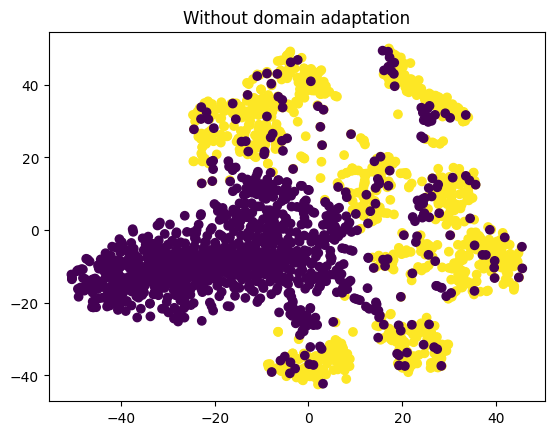

In [23]:
source_emb = extract_emb(naive_net, source_train_loader)
target_emb = extract_emb(naive_net, target_train_loader)

print("Original embeddings of source / target", source_emb.shape, target_emb.shape)

indexes = np.random.permutation(len(source_emb))[:1000]

emb = np.concatenate((source_emb[indexes], target_emb[indexes]))
domains = np.concatenate((np.ones((1000,)), np.zeros((1000,))))

print("Samples embeddings", emb.shape, domains.shape)

tsne = TSNE(n_components=2)

emb_2d = tsne.fit_transform(emb)
print("Dimension reduced embeddings", emb_2d.shape)

plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=domains)
plt.title("Without domain adaptation")

Желтые точки - это исходный набор данных (MNIST), а фиолетовые точки - это целевой набор данных (MNIST-M). Можно ясно увидеть, что они принадлежат разным пространствам, если используем наивную модель.

Original embeddings of source / target (60000, 2352) (60000, 2352)
Samples embeddings (2000, 2352) (2000,)
Dimension reduced embeddings (2000, 2)


Text(0.5, 1.0, 'With domain adaptation')

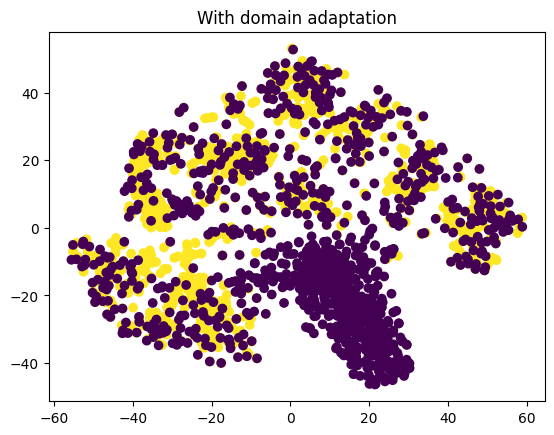

In [24]:
source_emb = extract_emb(dann, source_train_loader)
target_emb = extract_emb(dann, target_train_loader)

print("Original embeddings of source / target", source_emb.shape, target_emb.shape)

indexes = np.random.permutation(len(source_emb))[:1000]

emb = np.concatenate((source_emb[indexes], target_emb[indexes]))
domains = np.concatenate((np.ones((1000,)), np.zeros((1000,))))

print("Samples embeddings", emb.shape, domains.shape)

tsne = TSNE(n_components=2)

emb_2d = tsne.fit_transform(emb)
print("Dimension reduced embeddings", emb_2d.shape)

plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=domains)
plt.title("With domain adaptation")

Но с нашей DANN, хотя и не идеально, два домена гораздо более объединены. Это подтверждает нашу интуицию, что GRL заставляет сеть производить признаки, агностичные к домену.

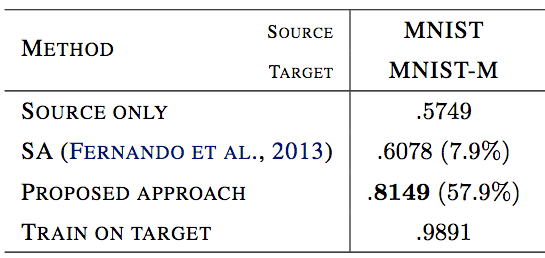

Наша модель все еще ниже производительности, заявленной в оригинальной статье. Мы можем попытаться дополнительно улучшить ее:

- использовать гораздо больше эпох
- изменить планировщик скорости обучения, чтобы он обновлялся на каждом шаге
- протестировать различную нормализацию
- различное планирование фактора GRL